# Project 2

## Used Modules

In [1]:
import pandas as pd # Data management
import matplotlib.pyplot as plt # Plotting datas
import statsmodels.api as sm # Some models
from tabulate import tabulate # Print tabulate datas
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from fredapi import Fred
fred = Fred(api_key='9d722abcde9cebf8cef3b4db21411253')
import numpy as np
from numpy.linalg import LinAlgError

## Data Visualisation functions

In [2]:
# Functions for data visualization

def print_results(pf_stats, title = ''):
    print(title)
    print(tabulate(pf_stats, headers = "keys",tablefmt='simple_grid', floatfmt=".6f", showindex=True))

def print_datas(datas, title = ''):
    print(title)
    datas = datas.dropna()
    result = pd.concat([datas.head(5),datas.tail(5)], axis=0)
    print(tabulate(result, headers = "keys", tablefmt='simple_grid', floatfmt=".4f"))
    
def plot_data(series_dict, title):
    plt.figure(figsize=(20,10))
    plt.title(title)
    for data, name in series_dict:
        data.index = [i.to_timestamp() for i in data.index]
        plt.plot(data, label = name)
    plt.legend()
    plt.show()
    
def plot_data_nt(series_dict, title):
    plt.figure(figsize=(20,10))
    plt.title(title)
    for data, name in series_dict:
    #data.index = [i.to_timestamp() for i in data.index]
        plt.plot(data, label = name)
    plt.legend()
    plt.show()
    
def plot_model_results(x, y, y_pred, model_name, lag, ax):
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'{model_name} (Lag {lag}), AUC = {roc_auc:.3f}')
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve - ' + model_name)
    ax.legend(loc='lower right')

## Data Extraction Functions

In [3]:
def threshold(x):
    if x >= 0.5:
        return 1
    else:
        return 0

def get_NBER_datas(start_date, end_date, nber_label):
    output = pd.DataFrame(fred.get_series('USRECQ', observation_start=start_date), columns=[nber_label])
    output = output.dropna()
    output.index = output.index.to_period('Q')
    return output

def get_term_datas(start_date, end_date, term_label):
    # Download 10-year U.S. Treasury bond yield and 3-month U.S. Treasury bill yield data
    yield_10yr = pd.DataFrame(fred.get_series('IRLTLT01USM156N', observation_start=start_date), columns = ['TS10Y'])
    yield_3mo = pd.DataFrame(fred.get_series('TB3MS'), columns = ['TS3MO'])
    output = yield_10yr.merge(yield_3mo, left_index = True, right_index = True)
    output = output.dropna()
    output[term_label] =  output['TS10Y'] - output['TS3MO'] 
    output = output.resample('Q').mean()
    output.index = output.index.to_period('Q')
    plot_data([(output['TERM'],'TERM'),(output['TS10Y'],'TS10Y'),(output['TS3MO'],'TS3MO')], 'Term spread datas')
    return output.drop(['TS10Y','TS3MO'], axis = 1)

## Utility

In [18]:
def create_lags(data, variable, max_lag):
    for i in range(1, max_lag+1):
        data[f'{variable}_lag{i}'] = data[variable].shift(i)
        data[f'{variable}_lag{i}'] = data[f'{variable}_lag{i}'].fillna(np.nanmean(data[f'{variable}_lag{i}']))
    return data

def predict_recession_prob(x, lag, model, quarters):
    latest_term = x.tail(quarters)
    prob_recession = model.predict(latest_term)
    return prob_recession.tolist()

## Points

### Parameters and datasets

/tmp/ipykernel_24052/1093403867.py:20: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  output = output.resample('Q').mean()


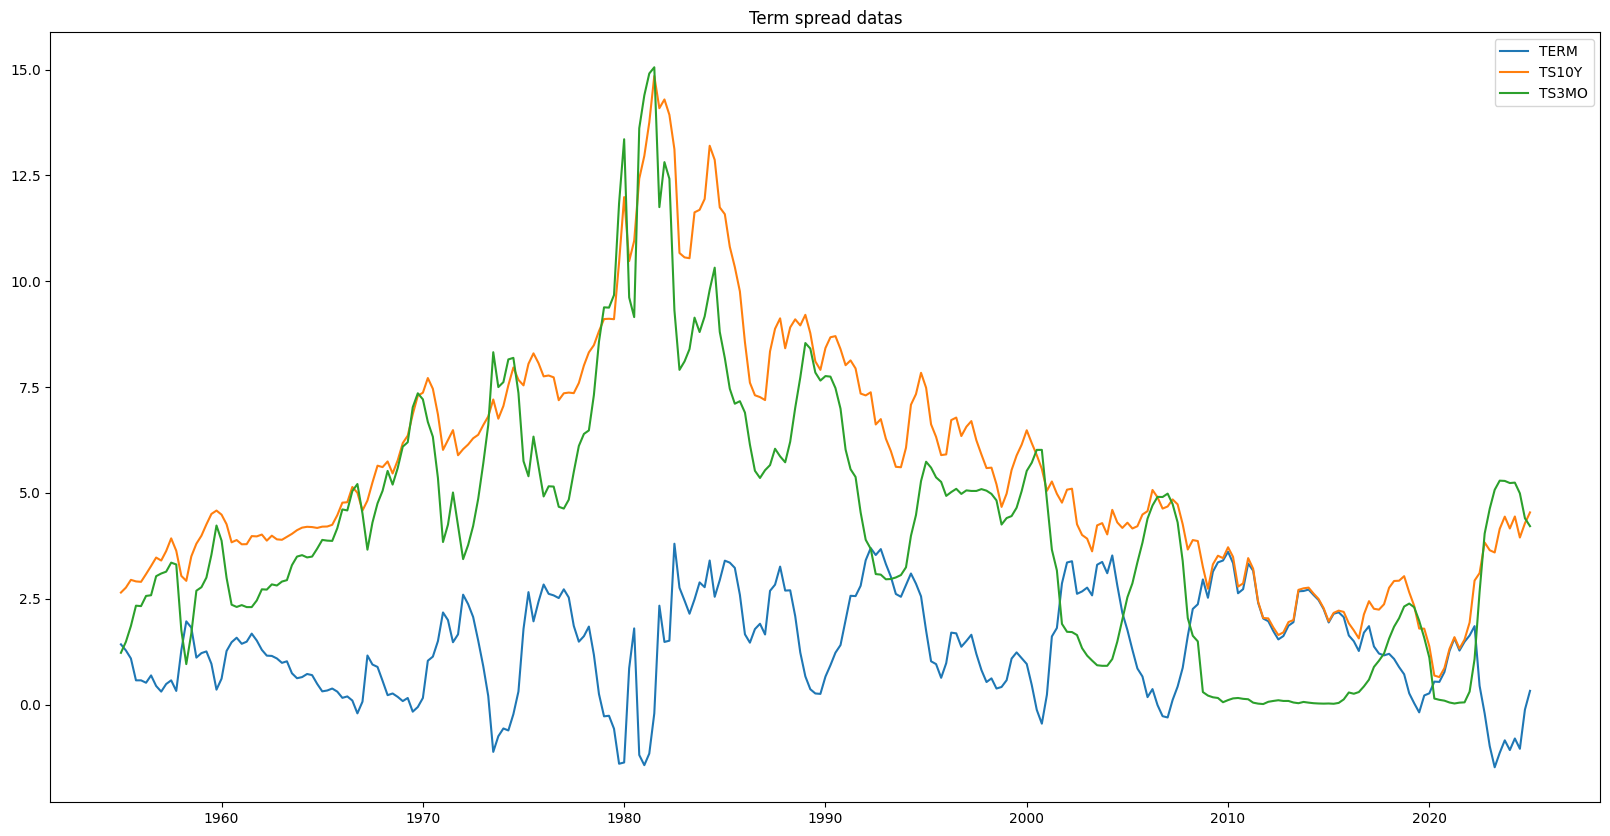

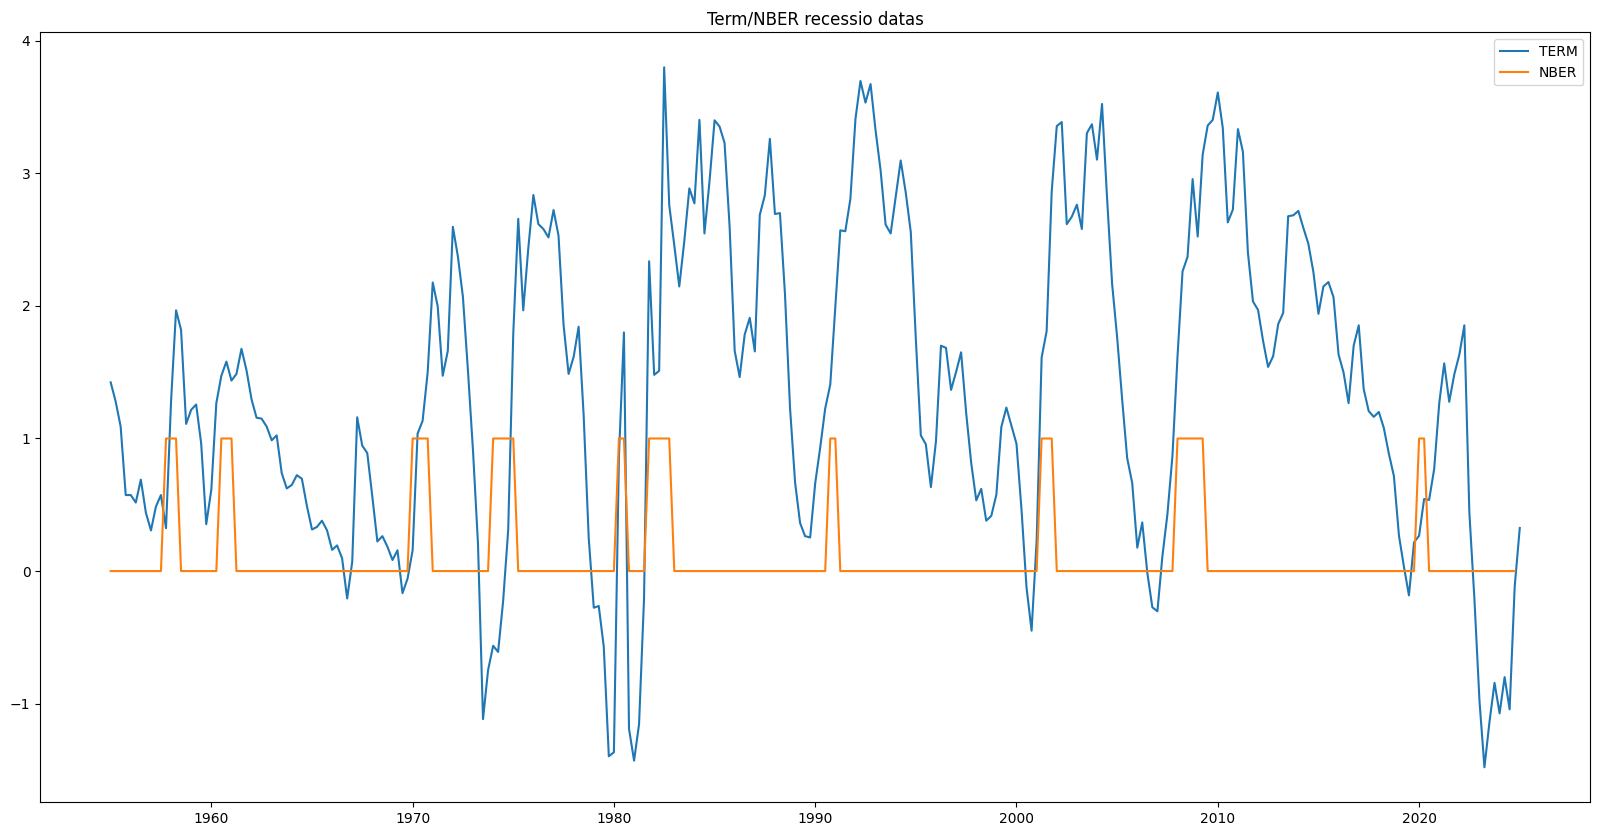

In [19]:
# Parameters
start_date = pd.to_datetime('1955-01-01')
end_date = pd.Timestamp.now().date()
term_label = 'TERM'
nber_label = 'NBER'

# Calculating TERM factor & retrieving NBER
term = get_term_datas(start_date, end_date, term_label)
nber = get_NBER_datas(start_date, end_date, nber_label)
plot_data([(term,'TERM'),(nber,'NBER')], 'Term/NBER recessio datas')

## Point 1 A

In each probit model you are going to see the model fitness in terms of R-sq. Report R-sq for the probit model.

In [ ]:
# Point 1 A    
def model_1a(term, nber, term_label, nber_label):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random guess')
    cb = pd.merge(term, nber, how='left', left_index = True, right_index = True)
    cb = create_lags(cb, term_label, 12)

    results = pd.DataFrame(columns=['Lag','R-squared','P-value'])
        
    for i in range(1, 13):
        x = sm.add_constant(cb[[f'{term_label}_lag{i}']]) # Indipendent variable
        y = cb[nber_label].fillna(0) # Dependent variable -> fillna must be changed

        model = sm.Probit(y, x).fit(disp=False)
        y_pred = model.predict(x)
        rsq = model.prsquared
        p_value = model.pvalues[f'{term_label}_lag{i}']
        plot_model_results(x, y, y_pred, 'Probit', i, ax)
        
        results.loc[i-1] = [i, rsq, p_value]
    return results

**P-Value** : p-value indicates the statistical significance of each lag term included in the model. A p-value less than 0.05 suggests that the term has a statistically significant impact on the dependent variable.

**R-Squared** : The R-squared value indicates the proportion of the variation in the dependent variable that can be explained by the independent variable or variables included in the model.


 --> Analysis in interval:  1955-01-01 00:00:00  -  2025-01-01 00:00:00 

Point 1.A - Probit model with report of R-squared
┌───────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬───────────┬───────────┬───────────┐
│           │        0 │        1 │        2 │        3 │        4 │        5 │        6 │        7 │        8 │         9 │        10 │        11 │
├───────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼───────────┼───────────┼───────────┤
│ Lag       │ 1.000000 │ 2.000000 │ 3.000000 │ 4.000000 │ 5.000000 │ 6.000000 │ 7.000000 │ 8.000000 │ 9.000000 │ 10.000000 │ 11.000000 │ 12.000000 │
├───────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼───────────┼───────────┼───────────┤
│ R-squared │ 0.020135 │ 0.105800 │ 0.191435 │ 0.236995 │ 0.226244 │ 0.165842 │ 0.116544 │ 0.076653 │ 0.048397 │  0.044887 │  0.04

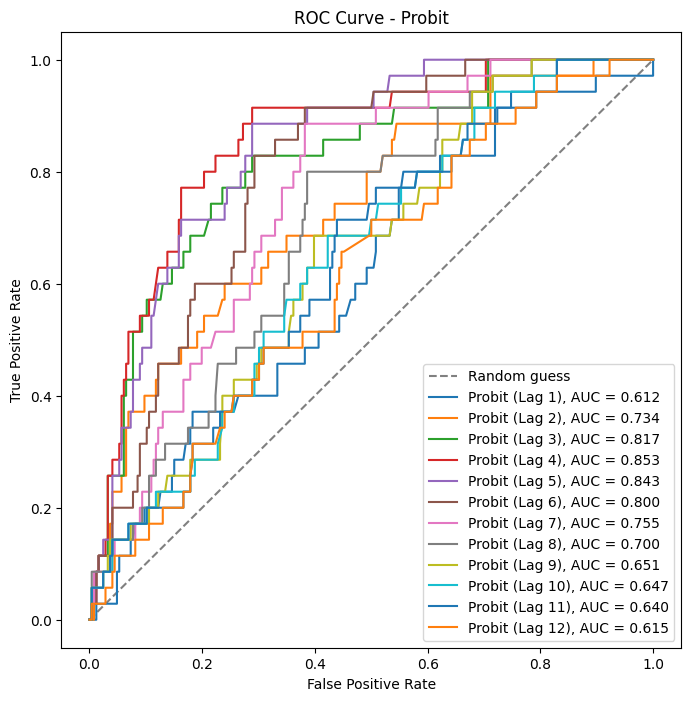

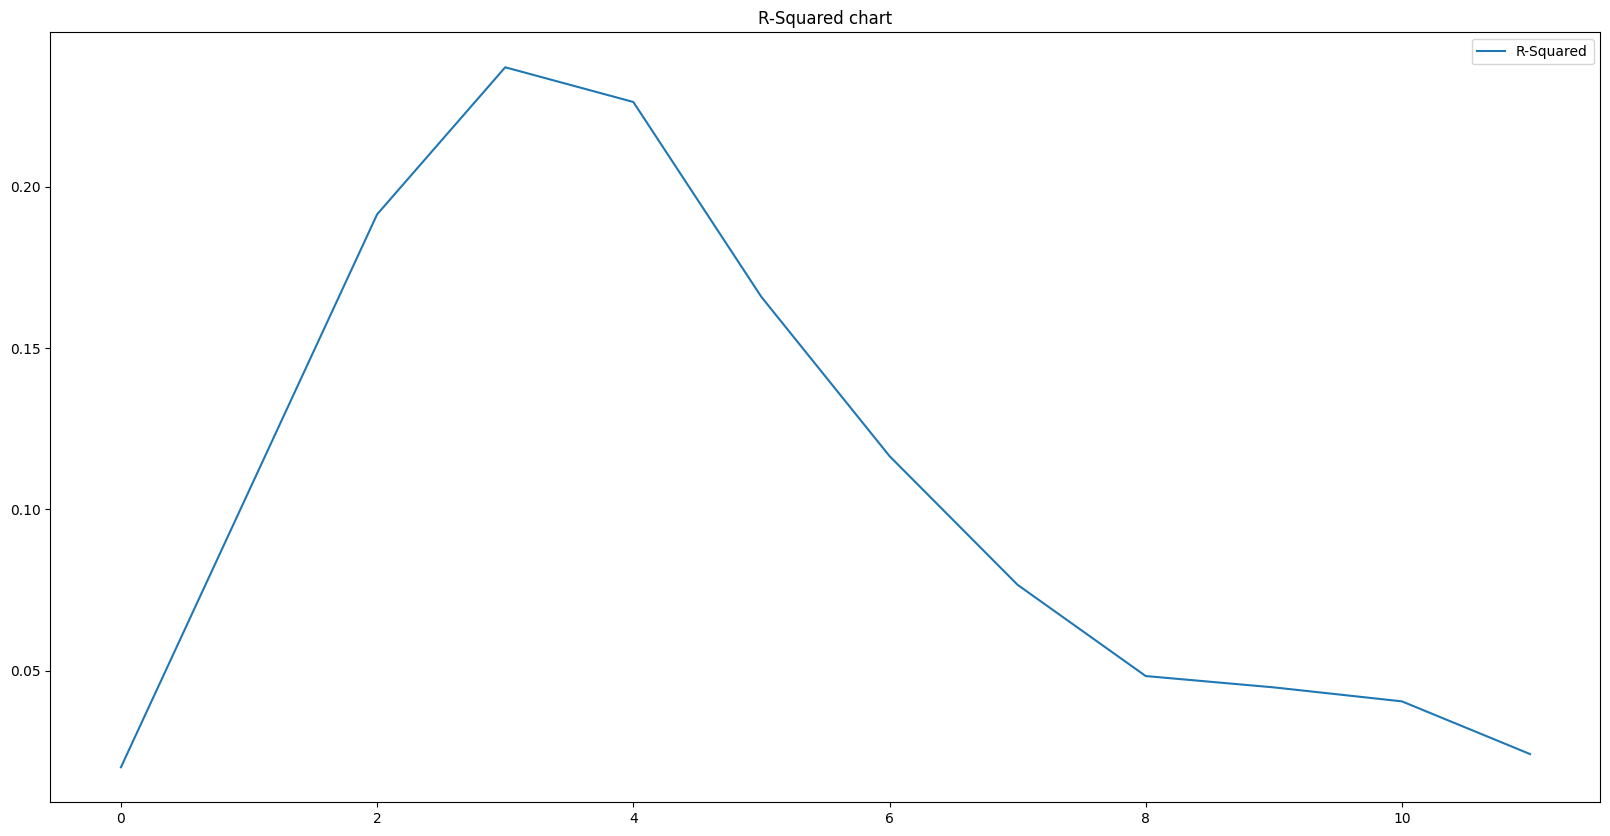

In [23]:
# Point 1 A
print('\n --> Analysis in interval: ', term.first_valid_index(), ' - ', term.last_valid_index(), '\n')
res_1a = model_1a(term, nber, term_label, nber_label)
print_results(res_1a.transpose(), 'Point 1.A - Probit model with report of R-squared')
plt.show()
plot_data_nt([(res_1a['R-squared'],'R-Squared')], 'R-Squared chart')

## Point 1 B

Predictions are never “1” or “0”. 

Use a different evaluation technique: Area Under the ROC curve (AUROC). Random guess would have an AUROC value of 0.5, so any model with AUROC greater than 0.5 is better than a guess. 

Calculate AUROC of each model (12 AUROC values). Report those in a tabular form. 

Use the full sample. In econometrics, we call it in-sample analysis (IS)


In [24]:
# Point 1 B

def models_1b(term, nber, term_label, nber_label):
    
    cb = pd.merge(nber, term, how='left', left_index = True, right_index = True)
    cb = create_lags(cb, term_label, 12)

    fig, axs = plt.subplots(2,2, figsize=(17,17))
    axs[0,0].set_title('Probit')
    axs[0,1].set_title('Logit')
    axs[1,0].set_title('PNN')
    axs[1,1].set_title('MLP')
    axs[0,0].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random guess') 
    axs[0,1].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random guess')
    axs[1,0].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random guess') 
    axs[1,1].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random guess')

    results = pd.DataFrame(columns=['Lag', 'Probit Auroc[IS]', 'Logit Auroc[IS]', 'PNN Auroc[IS]', 'MLP Auroc[IS]'])
    
    for i in range(1, 13):
        
        x = cb[[f'{term_label}_lag{i}']]
        y = cb[nber_label]

        # Probit model
        probit_model = sm.Probit(y, x).fit(disp=False)
        probit_y_pred = probit_model.predict(x)
        probit_auroc = roc_auc_score(y, probit_y_pred)
        plot_model_results(x, y, probit_y_pred, 'Probit', i, axs[0,0])
        
        # Logit model
        logit_model = sm.Logit(y, x).fit(disp=False)
        logit_y_pred = logit_model.predict(x)
        logit_auroc = roc_auc_score(y, logit_y_pred)
        plot_model_results(x, y, logit_y_pred, 'Logit', i, axs[0,1])
        
        # PNN model
        pnn_model = MLPClassifier(hidden_layer_sizes=(1,), activation='identity', solver='lbfgs').fit(x, y)
        pnn_y_pred = pnn_model.predict_proba(x)[:, 1]
        pnn_auroc = roc_auc_score(y, pnn_y_pred)
        plot_model_results(x, y, pnn_y_pred, 'PNN', i, axs[1,0])
        
        # MLP model
        mlp_model = MLPClassifier(hidden_layer_sizes=(6,), activation='relu', solver='adam', max_iter = 1000).fit(x, y)
        mlp_y_pred = mlp_model.predict_proba(x)[:, 1]
        mlp_auroc = roc_auc_score(y, mlp_y_pred)
        plot_model_results(x, y, mlp_y_pred, 'MLP', i, axs[1,1])
        
        results.loc[i-1] = [i, probit_auroc, logit_auroc, pnn_auroc, mlp_auroc]
        
    return results

Point 1.B - IS: In-Sample analysis
┌──────────────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬───────────┬───────────┬───────────┐
│                  │        0 │        1 │        2 │        3 │        4 │        5 │        6 │        7 │        8 │         9 │        10 │        11 │
├──────────────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼───────────┼───────────┼───────────┤
│ Lag              │ 1.000000 │ 2.000000 │ 3.000000 │ 4.000000 │ 5.000000 │ 6.000000 │ 7.000000 │ 8.000000 │ 9.000000 │ 10.000000 │ 11.000000 │ 12.000000 │
├──────────────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼───────────┼───────────┼───────────┤
│ Probit Auroc[IS] │ 0.613644 │ 0.736210 │ 0.820175 │ 0.856327 │ 0.845773 │ 0.802915 │ 0.757959 │ 0.702741 │ 0.653411 │  0.648863 │  0.639534 │  0.614227 │
├──────────────────┼─────────

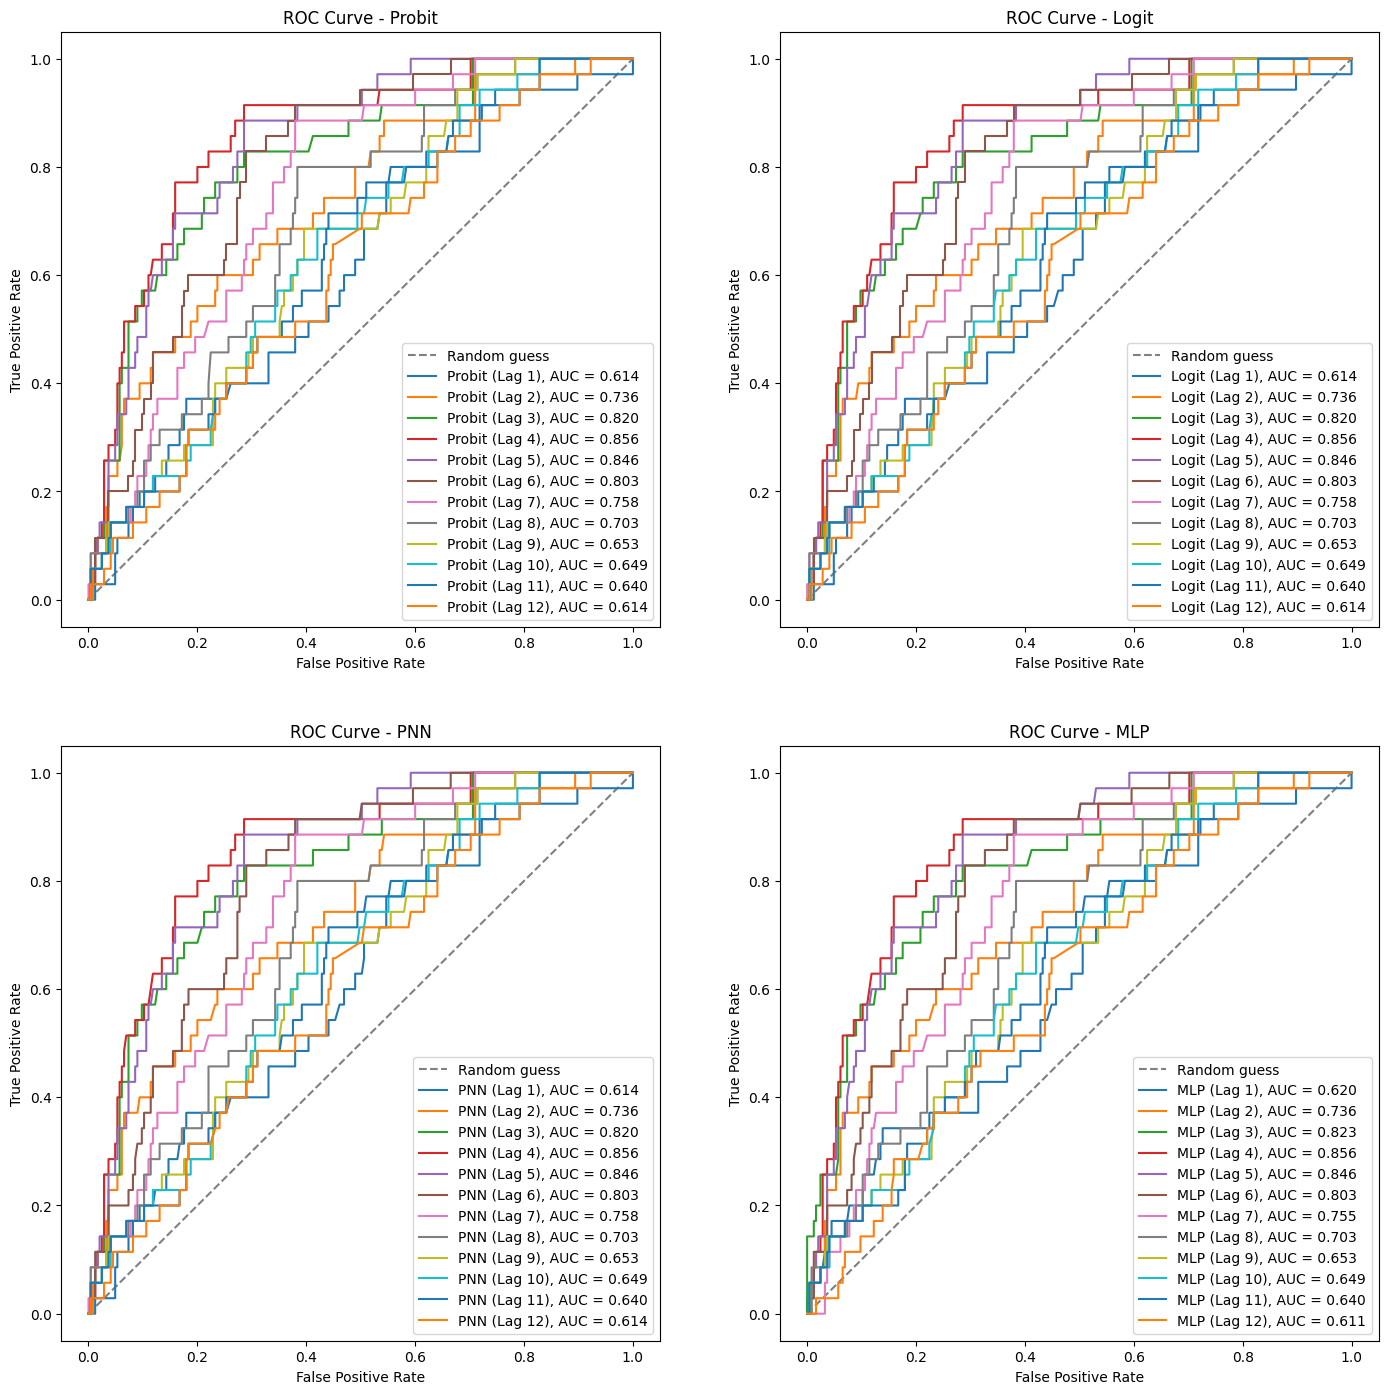

In [25]:
# Point 1 B
res_1b = models_1b(term, nber, term_label, nber_label)
print_results(res_1b.transpose(), 'Point 1.B - IS: In-Sample analysis')
plt.show()

## Point 1 C

Now use the AI and probit/logit prediction models. Compute AUROC values. 

Report those in a tabular form (you will have 36 AUROC values). 

Use 2/3 of data for training. Use 1/3 for evaluation. In econometrics, we call it pseudo-out-of-sample analysis (pos)

In [26]:
# Point 1 C

def models_1c(term, nber, term_label, nber_label, n_iter = 30):
    
    cb = pd.merge(nber, term, how='left', left_index = True, right_index = True)
    cb = create_lags(cb, term_label, 12)
    
    fig, axs = plt.subplots(2,2, figsize=(17,17))
    axs[0,0].set_title('Probit')
    axs[0,1].set_title('Logit')
    axs[1,0].set_title('PNN')
    axs[1,1].set_title('MLP')
    axs[0,0].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random guess') 
    axs[0,1].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random guess')
    axs[1,0].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random guess') 
    axs[1,1].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random guess')
    
    results = pd.DataFrame(columns=['Lag', 'Probit Auroc[OS]', 'Logit Auroc[OS]', 'PNN Auroc[OS]', 'MLP Auroc[OS]'])
    probit_auroc = []
    logit_auroc = []
    pnn_auroc = []
    mlp_auroc = []
    
    for i in range(1, 13):
        x = cb[[f'{term_label}_lag{i}']] # Indipendent variable
        y = cb[nber_label] # Dependent variable
        
        for _ in range(n_iter):
            try:
                x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle = False)

                # Probit model
                probit_model = sm.Probit(y_train, x_train).fit(disp=False, method = 'powell')
                probit_y_pred = probit_model.predict(x_test)
                probit_auroc.append(roc_auc_score(y_test, probit_y_pred))

                # Logit model
                logit_model = sm.Logit(y_train, x_train).fit(disp=False, method = 'powell')
                logit_y_pred = logit_model.predict(x_test)
                logit_auroc.append(roc_auc_score(y_test, logit_y_pred))

                # PNN model
                pnn_model = MLPClassifier(hidden_layer_sizes=(1,), activation='identity', solver='lbfgs', max_iter = 1200).fit(x_train, y_train)
                pnn_y_pred = pnn_model.predict_proba(x_test)[:, 1]
                pnn_auroc.append(roc_auc_score(y_test, pnn_y_pred))

                # MLP model
                mlp_model = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', solver='adam', max_iter = 1200).fit(x_train, y_train)
                mlp_y_pred = mlp_model.predict_proba(x_test)[:, 1]
                mlp_auroc.append(roc_auc_score(y_test, mlp_y_pred))
                
            except LinAlgError:
                print("Singular matrix encountered, skipping iteration.")
                
        plot_model_results(x_test, y_test, probit_y_pred, 'Probit', i, axs[0,0])
        plot_model_results(x_test, y_test, logit_y_pred, 'Logit', i, axs[0,1])
        plot_model_results(x_test, y_test, pnn_y_pred, 'PNN', i, axs[1,0])
        plot_model_results(x_test, y_test, mlp_y_pred, 'MLP', i, axs[1,1])
        
        results.loc[i-1] = [i, np.mean(probit_auroc), np.mean(logit_auroc), np.mean(pnn_auroc), np.mean(mlp_auroc)]

    return results

Points 1.C - OS: Out-Of-Sample analysis
┌──────────────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬───────────┬───────────┬───────────┐
│                  │        0 │        1 │        2 │        3 │        4 │        5 │        6 │        7 │        8 │         9 │        10 │        11 │
├──────────────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼───────────┼───────────┼───────────┤
│ Lag              │ 1.000000 │ 2.000000 │ 3.000000 │ 4.000000 │ 5.000000 │ 6.000000 │ 7.000000 │ 8.000000 │ 9.000000 │ 10.000000 │ 11.000000 │ 12.000000 │
├──────────────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼───────────┼───────────┼───────────┤
│ Probit Auroc[OS] │ 0.491402 │ 0.534722 │ 0.593254 │ 0.642692 │ 0.683201 │ 0.713735 │ 0.736300 │ 0.754547 │ 0.767122 │  0.775198 │  0.777237 │  0.771881 │
├──────────────────┼────

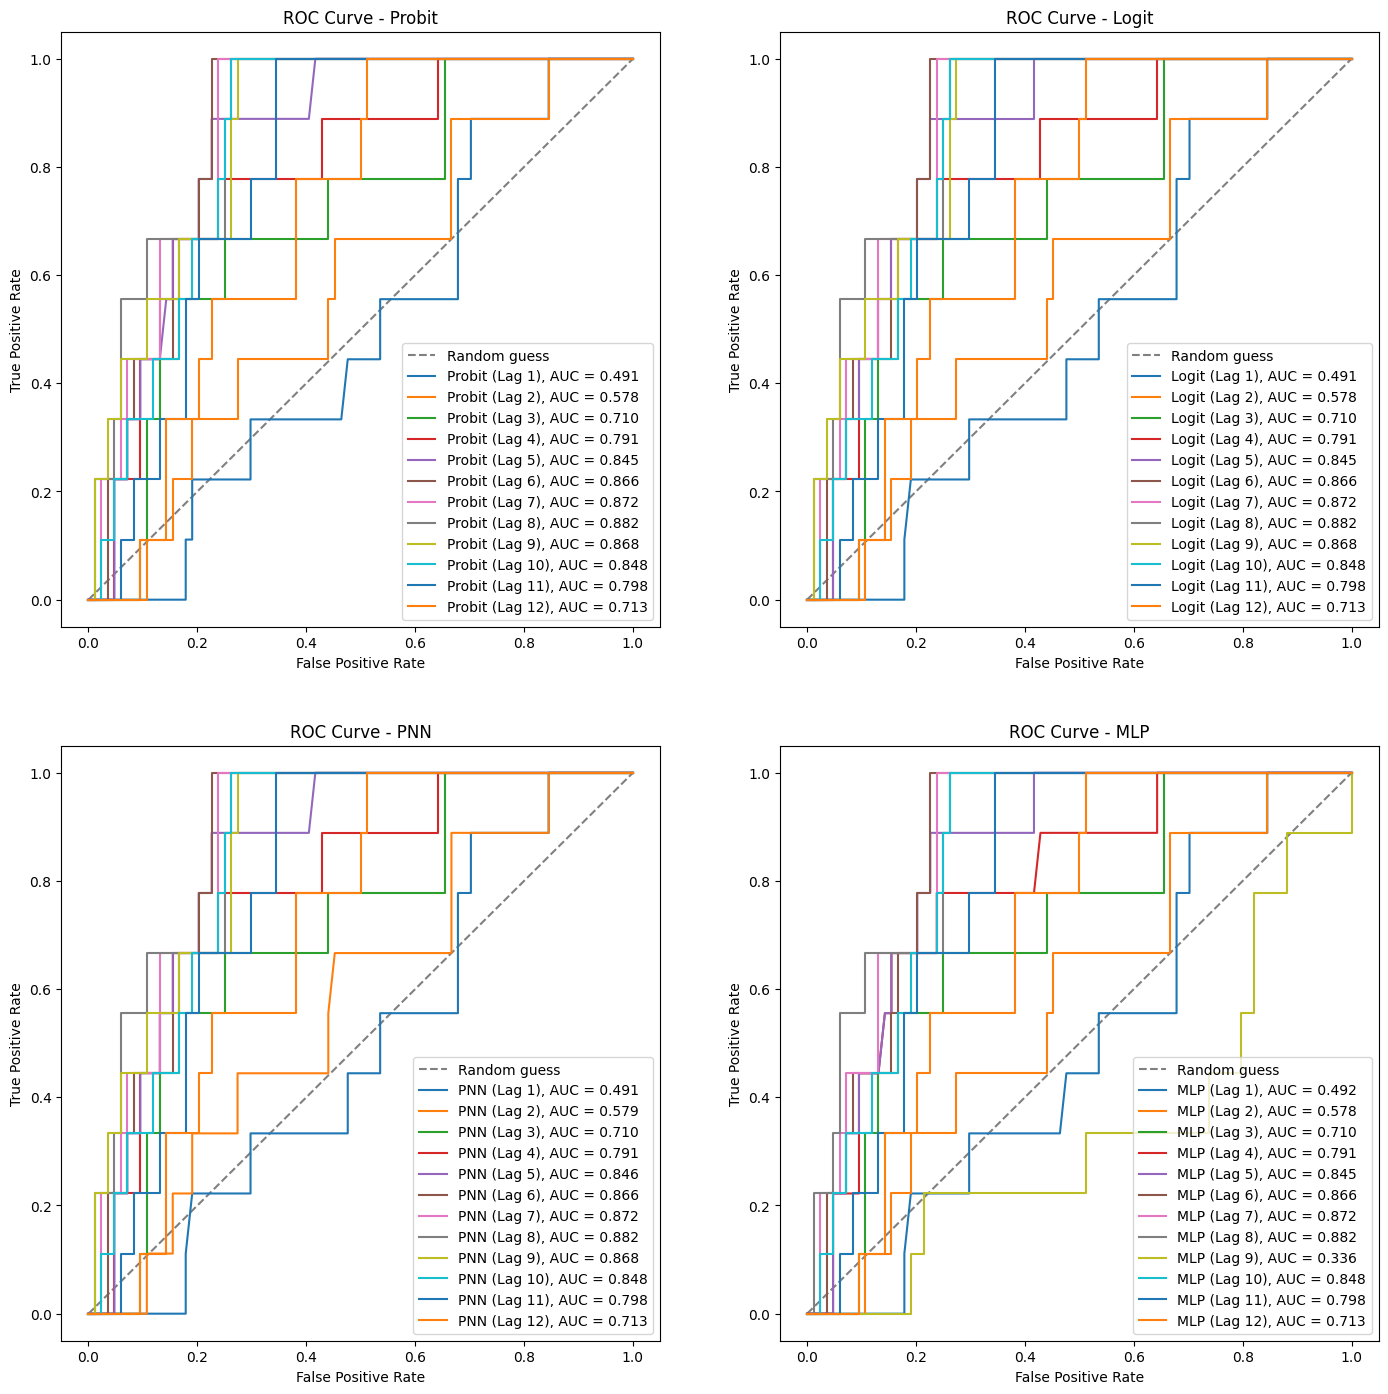

In [27]:
# Point 1 C
res_1c = models_1c(term, nber, term_label, nber_label, 20)
print_results(res_1c.transpose(), 'Points 1.C - OS: Out-Of-Sample analysis')
plt.show()

## Point 2

Assume that if we are in a “Recession” today, the “Recession” today is a good predictor of recession tomorrow. 

That is, in each quarter, add a lag of “Recession” as a predictor. As a result, in each quarter, you have 2 explanatory variables – make sure both have the same lag, otherwise prediction is faulty.

Redo part 1, step c, with the new model.


In [28]:
# Point 2
def models_2(term, nber, term_label, nber_label, n_iter = 30):
    
    cb = pd.merge(nber, term, how='left', left_index = True, right_index = True)
    cb = create_lags(cb, term_label, 12)
    cb = create_lags(cb, nber_label, 12)
    fig, axs = plt.subplots(2,2, figsize=(17,17))
    axs[0,0].set_title('Probit')
    axs[0,1].set_title('Logit')
    axs[1,0].set_title('PNN')
    axs[1,1].set_title('MLP')
    axs[0,0].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random guess') 
    axs[0,1].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random guess')
    axs[1,0].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random guess') 
    axs[1,1].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random guess')

    results = pd.DataFrame(columns=['Lag', 'Probit Auroc[IS]', 'Logit Auroc[IS]', 'PNN Auroc[IS]', 'MLP Auroc[IS]'])
    probit_auroc = []
    logit_auroc = []
    pnn_auroc = []
    mlp_auroc = []
    
    for i in range(1, 13):
        x = cb[[f'{term_label}_lag{i}', f'{nber_label}_lag{i}']] # Indipendent variable
        y = cb[nber_label] # Dependent variable
        
        for _ in range(n_iter):
            try:
                x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle = False)

                # Probit model
                probit_model = sm.Probit(y_train, x_train).fit(disp=False, method = 'powell')
                probit_y_pred = probit_model.predict(x_test)
                probit_auroc.append(roc_auc_score(y_test, probit_y_pred))

                # Logit model
                logit_model = sm.Logit(y_train, x_train).fit(disp=False, method = 'powell')
                logit_y_pred = logit_model.predict(x_test)
                logit_auroc.append(roc_auc_score(y_test, logit_y_pred))

                # PNN model
                pnn_model = MLPClassifier(hidden_layer_sizes=(1,), activation='identity', solver='lbfgs', max_iter = 1200).fit(x_train, y_train)
                pnn_y_pred = pnn_model.predict_proba(x_test)[:, 1]
                pnn_auroc.append(roc_auc_score(y_test, pnn_y_pred))

                # MLP model
                mlp_model = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', solver='adam', max_iter = 1200).fit(x_train, y_train)
                mlp_y_pred = mlp_model.predict_proba(x_test)[:, 1]
                mlp_auroc.append(roc_auc_score(y_test, mlp_y_pred))
                
            except LinAlgError:
                print("Singular matrix encountered, skipping this iteration.")
        
        
        plot_model_results(x_test, y_test, probit_y_pred, 'Probit', i, axs[0,0])
        plot_model_results(x_test, y_test, logit_y_pred, 'Logit', i, axs[0,1])
        plot_model_results(x_test, y_test, pnn_y_pred, 'PNN', i, axs[1,0])
        plot_model_results(x_test, y_test, mlp_y_pred, 'MLP', i, axs[1,1])
        results.loc[i-1] = [i, np.mean(probit_auroc), np.mean(logit_auroc), np.mean(pnn_auroc), np.mean(mlp_auroc)]

    return results

Points 1.C
┌──────────────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬───────────┬───────────┬───────────┐
│                  │        0 │        1 │        2 │        3 │        4 │        5 │        6 │        7 │        8 │         9 │        10 │        11 │
├──────────────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼───────────┼───────────┼───────────┤
│ Lag              │ 1.000000 │ 2.000000 │ 3.000000 │ 4.000000 │ 5.000000 │ 6.000000 │ 7.000000 │ 8.000000 │ 9.000000 │ 10.000000 │ 11.000000 │ 12.000000 │
├──────────────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼───────────┼───────────┼───────────┤
│ Probit Auroc[IS] │ 0.825397 │ 0.770503 │ 0.757496 │ 0.761574 │ 0.774603 │ 0.791667 │ 0.804611 │ 0.815476 │ 0.822604 │  0.826587 │  0.825517 │  0.818232 │
├──────────────────┼──────────┼──────────┼──────────┼

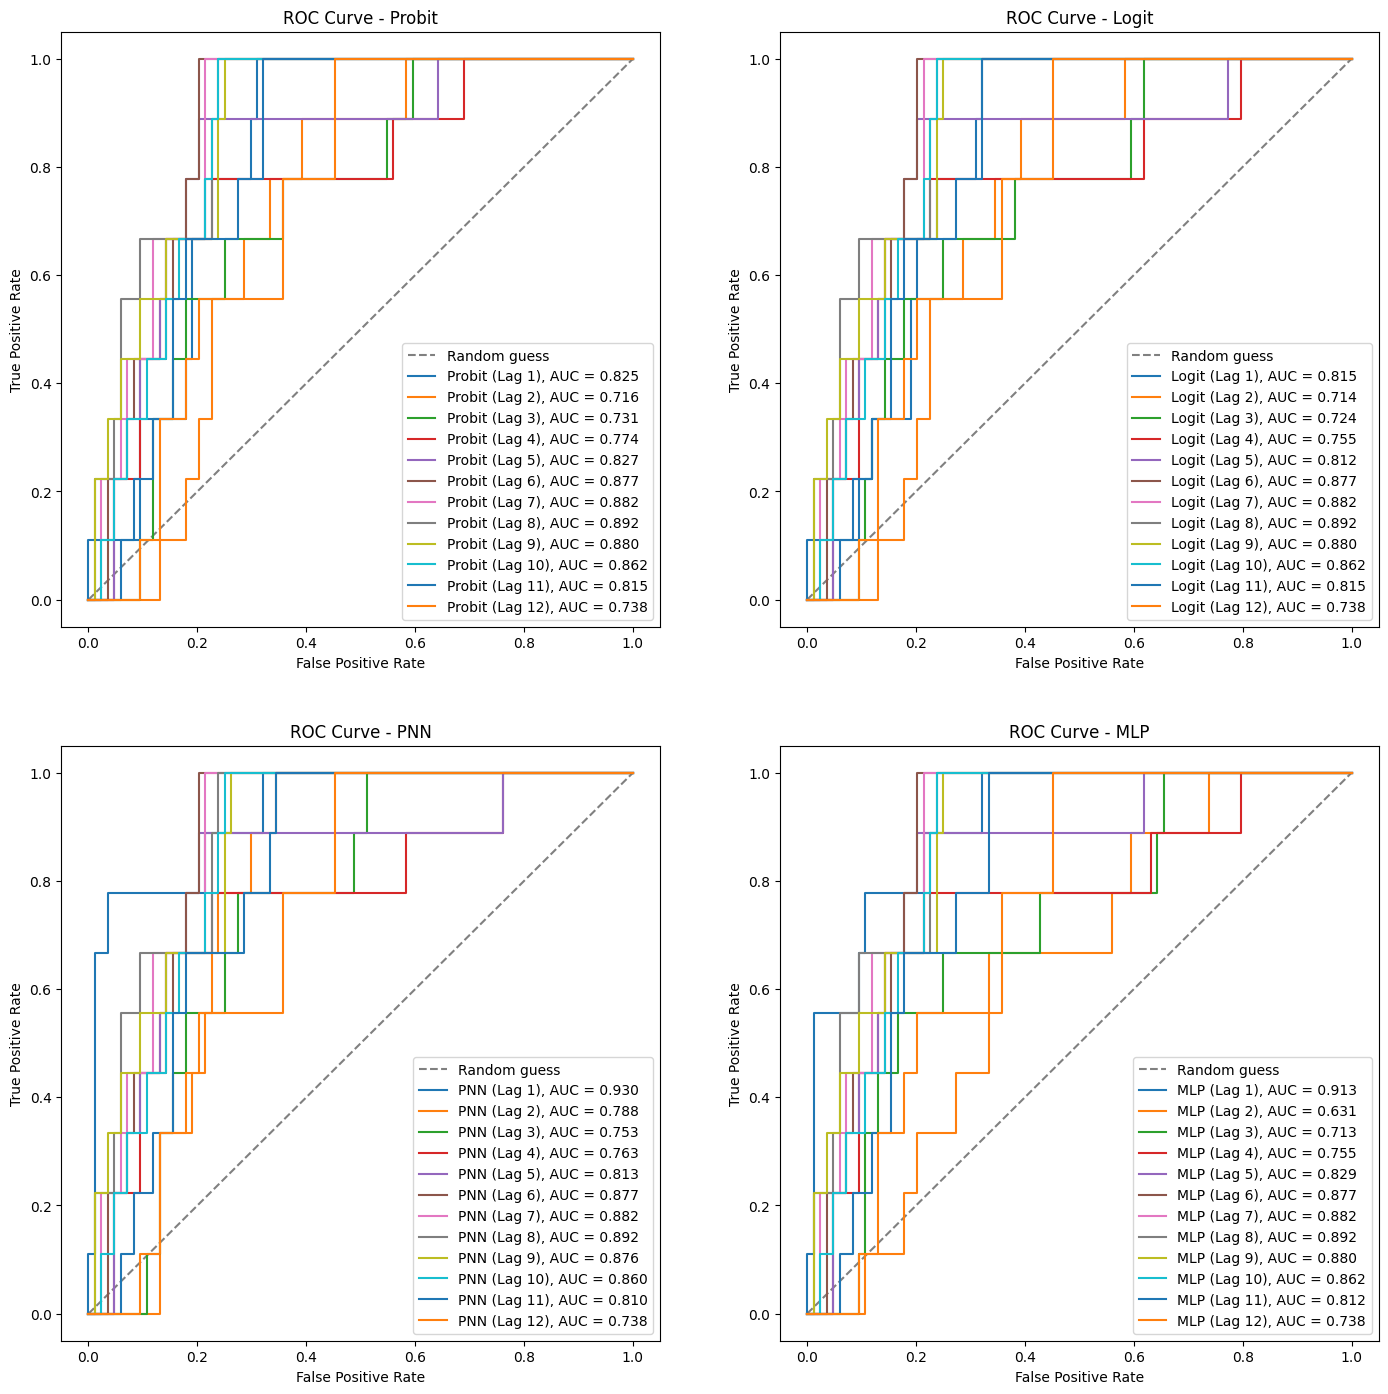

In [29]:
# Point 2
res_2 = models_2(term, nber, term_label, nber_label, 30)
print_results(res_2.transpose(), 'Points 1.C')
plt.show()